In [5]:
import pandas as pd
import warnings
import sys
import matplotlib.pyplot as plt

from datetime import datetime
from binomialModel import BinomialModel

sys.path.insert(0, '..')

from utils import *

warnings.filterwarnings("ignore")

In [6]:
ticker = 'AAPL'
stock_data = fetch_stock_data(ticker)
expiry, calls, puts = fetch_options_data(ticker, 10)
expiry = pd.to_datetime(expiry)
days_to_expiry = abs((expiry - datetime.now()).days)

[*********************100%***********************]  1 of 1 completed


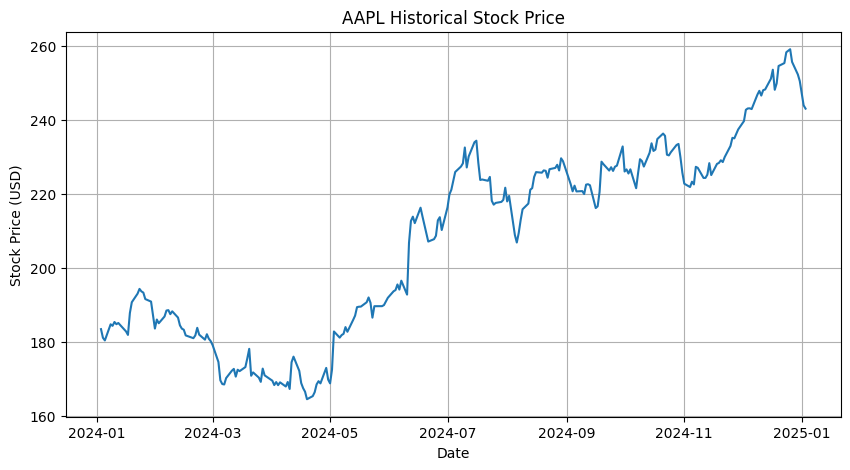

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)

In [9]:
# Get historical volatility
historical_volatility = calculate_historical_volatility(stock_data)

# Calculate the Binomial model
underlying_price = float(stock_data['Close'].iloc[-1])
# strike_price is variable from options_data
years_to_expiry = float(days_to_expiry / 365)
risk_free_rate = float(fetch_risk_free_rate()) / 100

# Create a pandas DataFrame to store the results
call_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
put_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['lastPrice']):
    call = BinomialModel(S=underlying_price, K=strike, T=years_to_expiry, r=risk_free_rate, sigma=historical_volatility, q=fetch_dividend_yield(ticker))

    data = pd.Series({
        "Strike": strike,
        "Calculated Price": call.option_price(call=True),
        "Last Price": last_price,
        "Error": abs(call.option_price(call=True) - last_price) / last_price
    })
    call_results = pd.concat([call_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_call_error = call_results[call_results['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['lastPrice']):
    put = BinomialModel(S=underlying_price, K=strike, T=years_to_expiry, r=risk_free_rate, sigma=historical_volatility, q=fetch_dividend_yield(ticker))

    data = pd.Series({
        "Strike": strike,
        "Calculated Price": put.option_price(call=False),
        "Last Price": last_price,
        "Error": abs(put.option_price(call=False) - last_price) / last_price
    })
    put_results = pd.concat([put_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_put_error = put_results[put_results['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_put_error)):.2f}%")

[*********************100%***********************]  1 of 1 completed


Average Call Error: 0.15%
Average Put Error: 0.46%
